# Segmentation of LUNGS from CT scans.

In [ ]:
# Import libraries
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from keras import callbacks
from keras import backend as K
from tensorflow import keras
from __future__ import division
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.optimizers import *
from keras.layers import *        
import tensorflow as tf

%matplotlib inline

## Download the data
Source: https://www.kaggle.com/kmader/finding-lungs-in-ct-data

In [ ]:
# Download url of lung images.
url = "https://github.com/hasibzunair/cu-comp478-lab/releases/download/v0.0.1/LUNGS_images.npy"
filename = os.path.join(os.getcwd(), "LUNGS_images.npy")
keras.utils.get_file(filename, url)

# Download url of lung segmentation masks
url = "https://github.com/hasibzunair/cu-comp478-lab/releases/download/v0.0.1/LUNGS_mask.npy"
filename = os.path.join(os.getcwd(), "LUNGS_mask.npy")
keras.utils.get_file(filename, url)

267657216/267649152 [==============================] - 4s 0us/step


'/content/LUNGS_mask.npy'

## Load the data

In [ ]:
data = np.load("LUNGS_images.npy") 
labels = np.load("LUNGS_mask.npy")
print(data.shape, labels.shape)

(1021, 256, 256, 1) (1021, 256, 256, 1)


## Visualize the data

(256, 256, 1) (256, 256, 1)


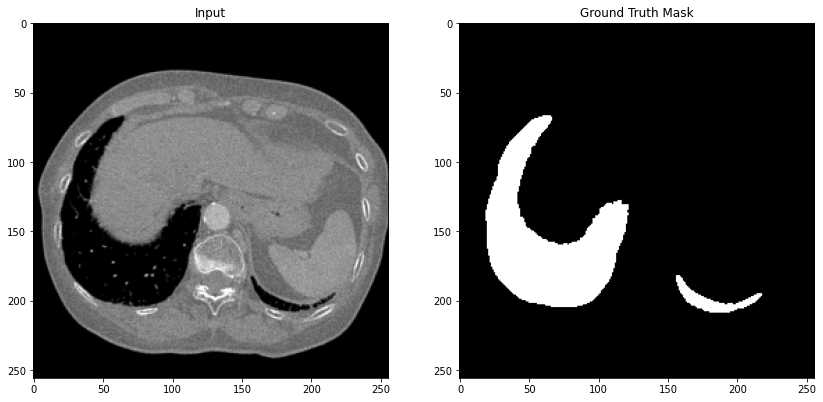

(256, 256, 1) (256, 256, 1)


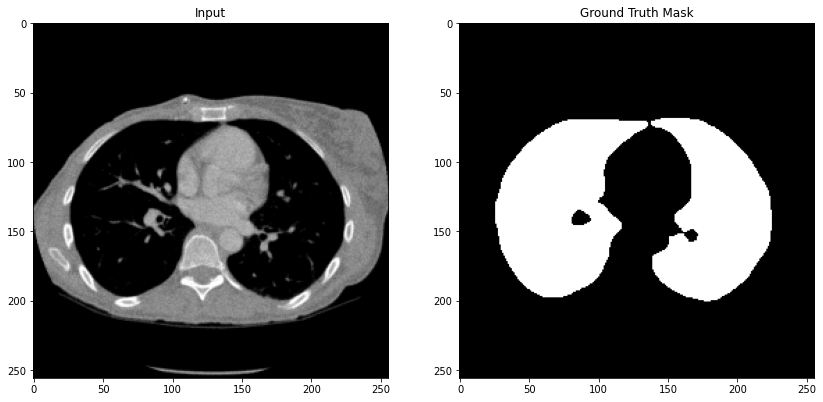

(256, 256, 1) (256, 256, 1)


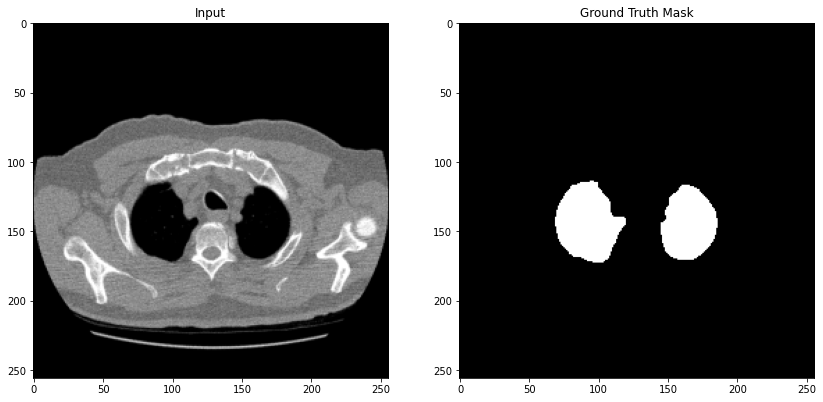

(256, 256, 1) (256, 256, 1)


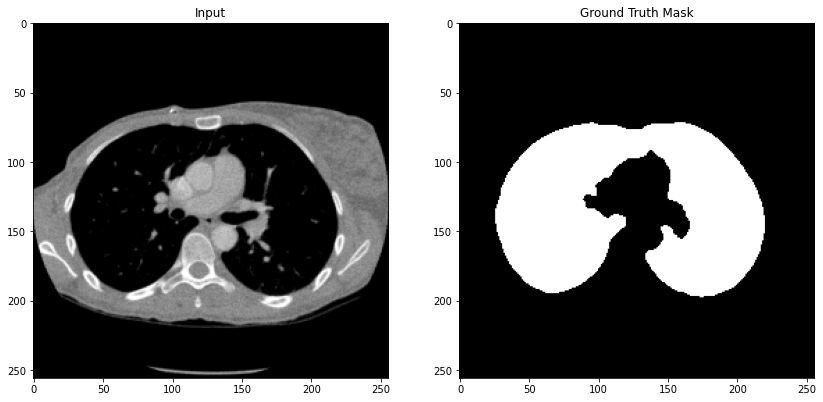

(256, 256, 1) (256, 256, 1)


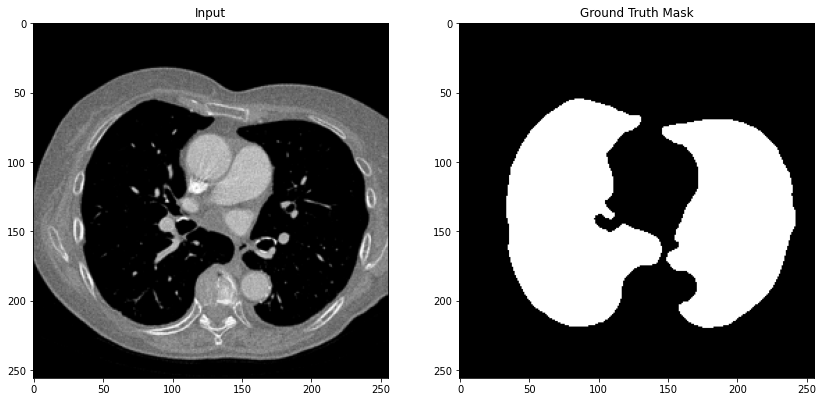

(256, 256, 1) (256, 256, 1)


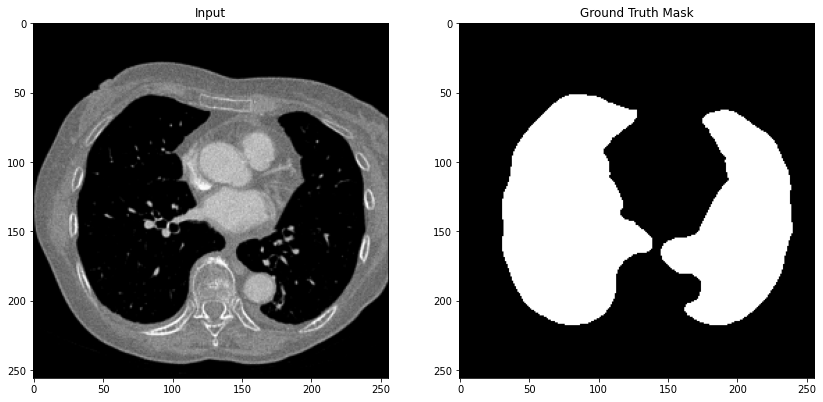

(256, 256, 1) (256, 256, 1)


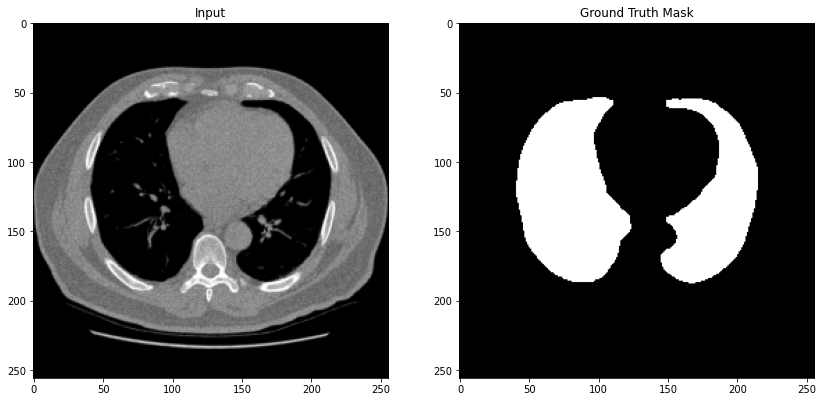

(256, 256, 1) (256, 256, 1)


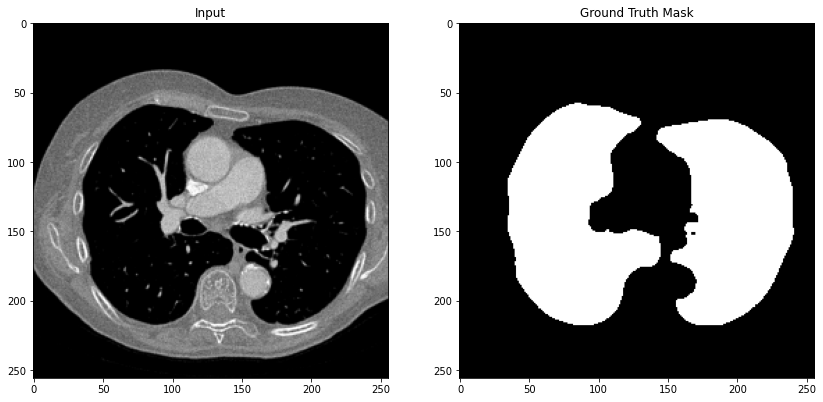

(256, 256, 1) (256, 256, 1)


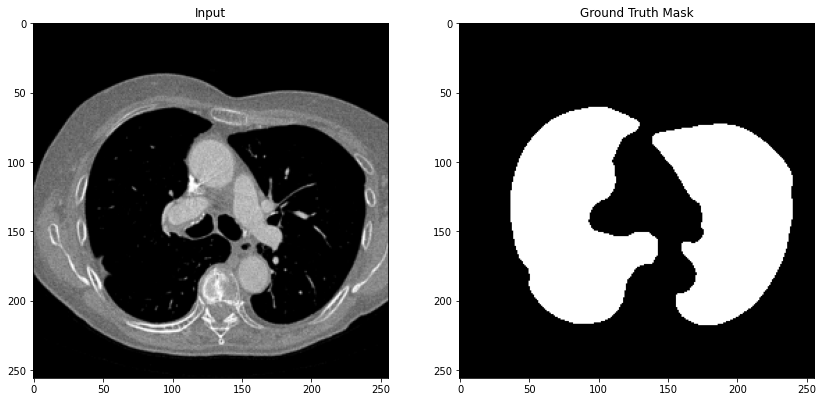

(256, 256, 1) (256, 256, 1)


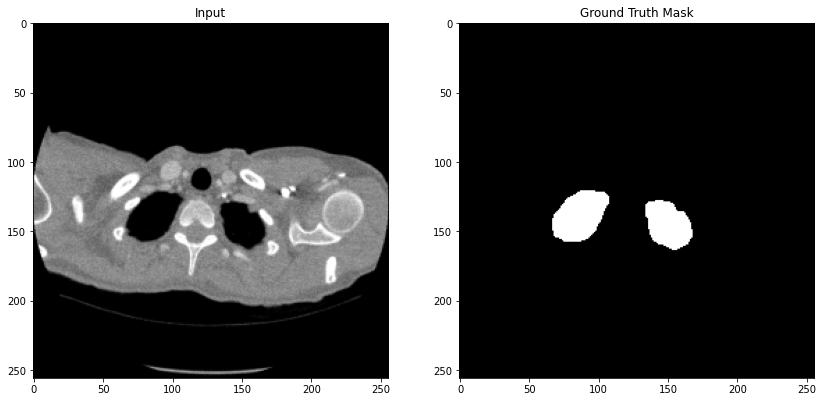

In [ ]:
# define 10 random numbers
rand = [random.randint(0, 1000) for _ in range(10)]

for img, mask in zip(data[rand], labels[rand]):
    print(img.shape, mask.shape)
    img = np.squeeze(img, axis=-1) # change to H, W
    mask = np.squeeze(mask, axis=-1) # change to H, W

    plt.figure(figsize=(14,12))
    plt.subplot(1,2,1)
    plt.title('Input')
    plt.imshow(img, cmap='gray')
    plt.grid(False)

    plt.subplot(1,2,2)
    plt.grid(False)
    plt.title('Ground Truth Mask')
    plt.imshow(mask, cmap='gray')
    plt.show()

## Define model and metrics

In [ ]:
# From https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def unet(input_size = (256,256,1)):
    "Baseline Unet"
    
    inputs = Input(input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # Binary segmentation
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) 

    model = Model(inputs=[inputs], outputs=[conv10])

    # Compile model with optim and loss
    optim = 'adam' 
    
    # If bin seg, use bce loss, or categorical_crossentropy for multi class
    loss_func = 'binary_crossentropy'  
    
    model.compile(optimizer = optim, loss = loss_func, metrics = [jacard, dice_coef])

    return model


# Metrics
smooth = 1
def jacard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection/union


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## Helper function to plot progress of training model

In [ ]:
# Plot and save accuravy loss graphs individually
def plot_loss_accu(history):
    loss = history.history['loss'][1:]
    val_loss = history.history['val_loss'][1:]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training and validation loss')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.grid(True)
    plt.show()
    
    loss = history.history['jacard'][1:]
    val_loss = history.history['val_jacard'][1:]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation jaccard index')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.grid(True)
    plt.show()

## Build model

In [ ]:
# Build model
model = unet(input_size = (data.shape[1], data.shape[2], data.shape[-1]))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Split data into train and test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, shuffle=True, test_size=0.20, random_state=42)
print("Data shapes-------> ", x_train.shape, x_test.shape, y_train.shape, y_test.shape)

Data shapes------->  (816, 256, 256, 1) (205, 256, 256, 1) (816, 256, 256, 1) (205, 256, 256, 1)


## Train model

Epoch 1/10
102/102 [==============================] - 54s 164ms/step - loss: 0.6002 - jacard: 0.3233 - dice_coef: 0.4650 - val_loss: 0.2027 - val_jacard: 0.5984 - val_dice_coef: 0.7481
Epoch 2/10
102/102 [==============================] - 15s 143ms/step - loss: 0.3654 - jacard: 0.3868 - dice_coef: 0.5340 - val_loss: 0.0305 - val_jacard: 0.9098 - val_dice_coef: 0.9527
Epoch 3/10
102/102 [==============================] - 15s 144ms/step - loss: 0.0252 - jacard: 0.9258 - dice_coef: 0.9614 - val_loss: 0.0194 - val_jacard: 0.9382 - val_dice_coef: 0.9681
Epoch 4/10
102/102 [==============================] - 15s 146ms/step - loss: 0.0185 - jacard: 0.9395 - dice_coef: 0.9688 - val_loss: 0.0156 - val_jacard: 0.9521 - val_dice_coef: 0.9754
Epoch 5/10
102/102 [==============================] - 15s 147ms/step - loss: 0.0149 - jacard: 0.9490 - dice_coef: 0.9738 - val_loss: 0.0117 - val_jacard: 0.9631 - val_dice_coef: 0.9812
Epoch 6/10
102/102 [==============================] - 15s 148ms/step - loss

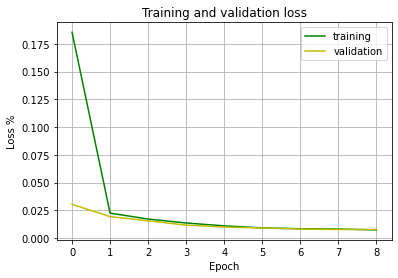

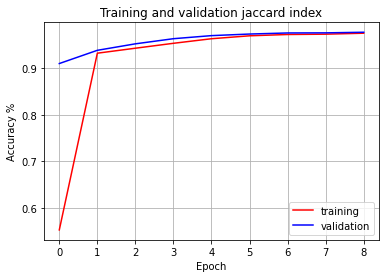

In [ ]:
# Train
batch_size = 8
epochs = 10
history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                shuffle=True)

# Plot model training history
plot_loss_accu(history)

## Test model

In [ ]:
# Evaluate trained model using Jaccard and Dice metric
yp = None
yp = model.predict(x=x_test, batch_size=batch_size, verbose=0)
#Round off boolean masks
yp = np.round(yp,0) 

## Visualization of predicted masks

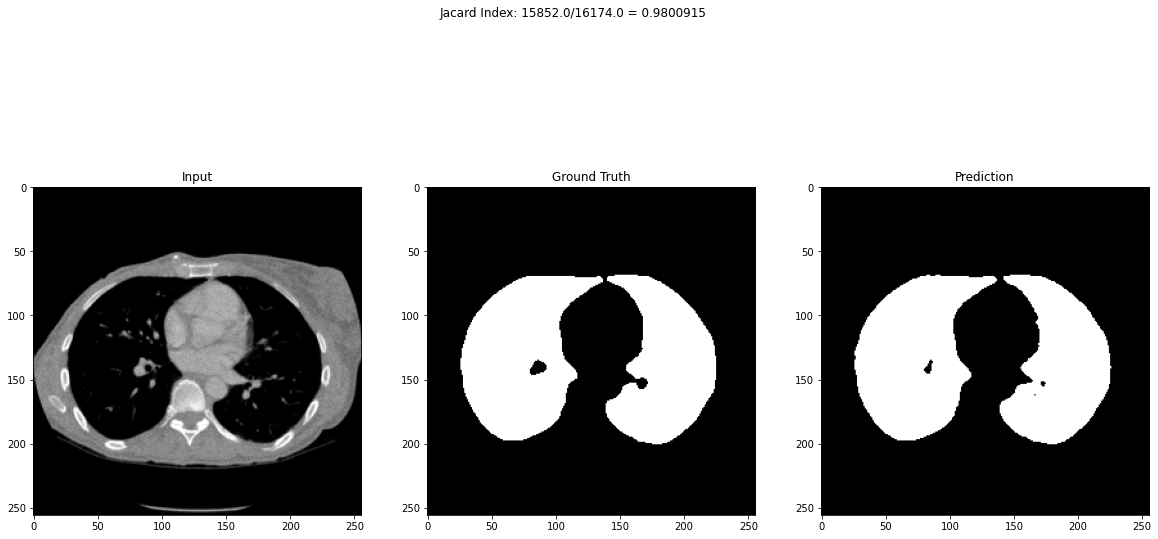

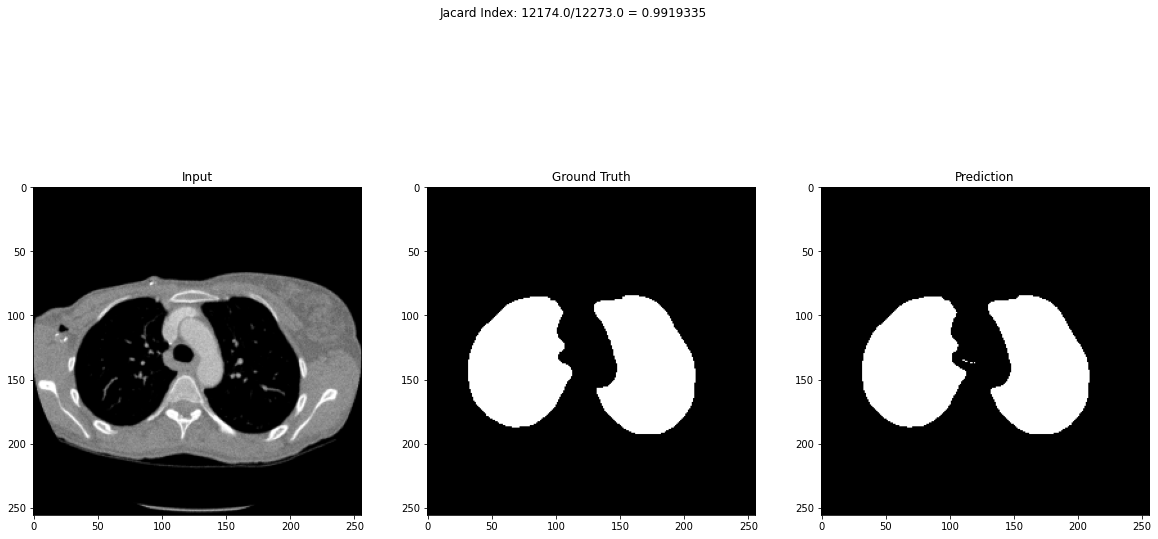

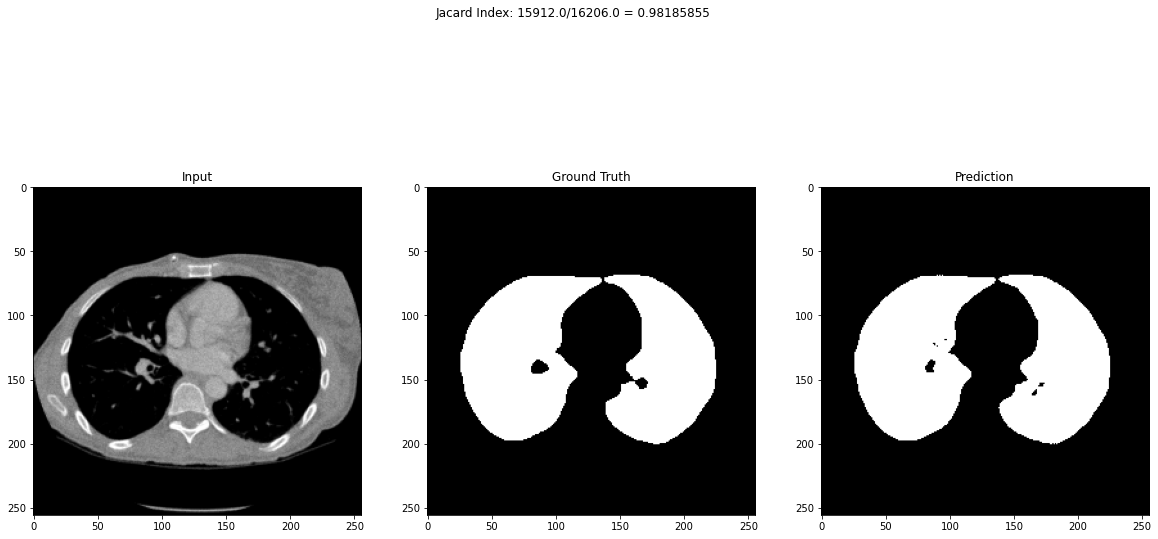

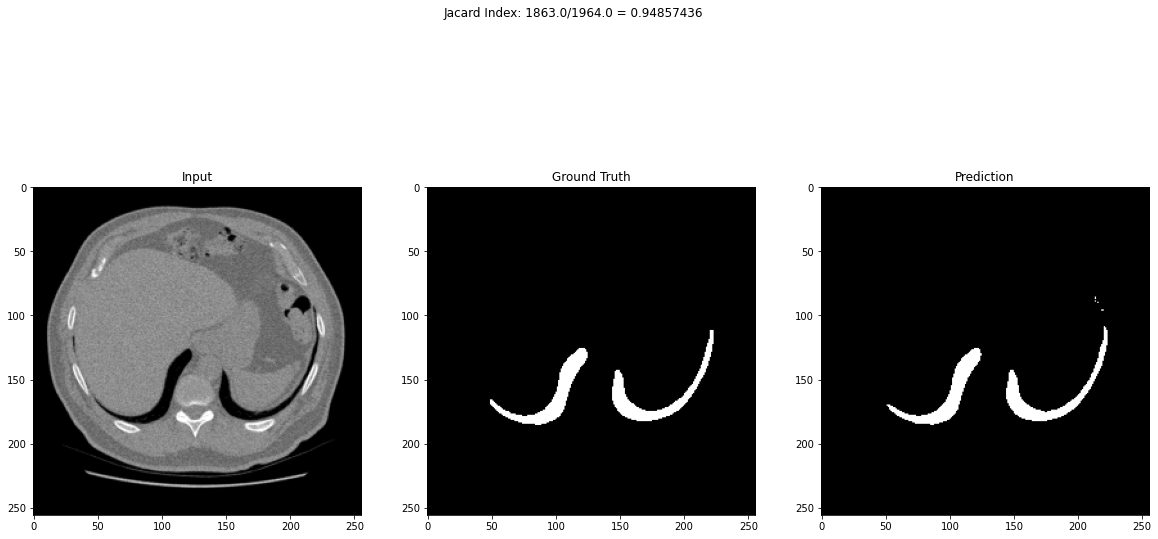

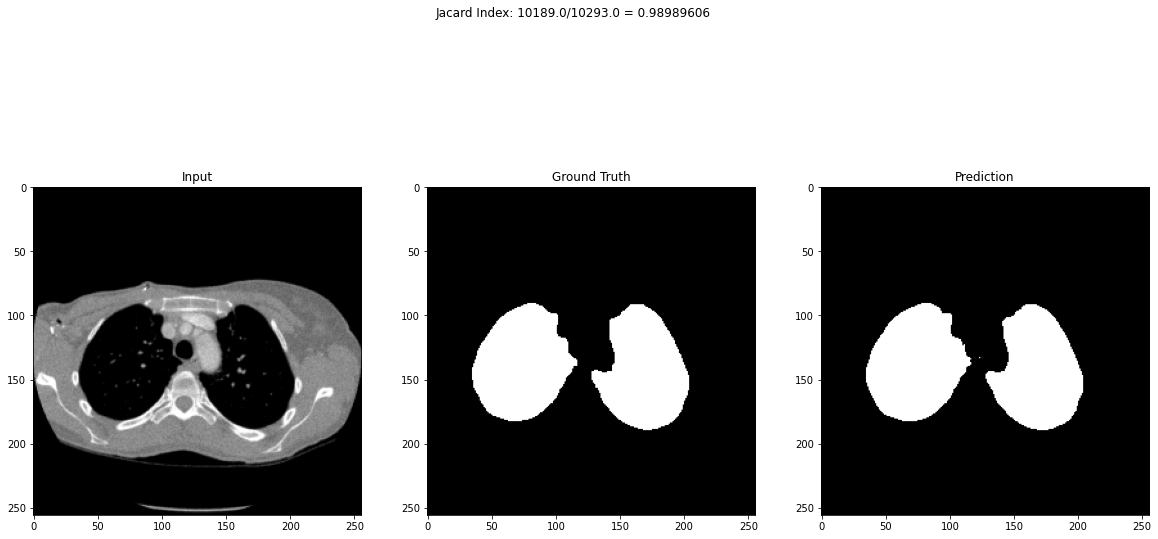

In [ ]:
for i in range(5):
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    if len(x_test[i].shape) >= 2:
        plt.grid(False)
        plt.imshow(x_test[i].squeeze(), cmap='gray') # 1-channel image
    else:
        plt.grid(False)
        plt.imshow(x_test[i]) # 3-channel
        
    plt.title('Input')
    plt.subplot(1,3,2)
    plt.grid(False)
    plt.imshow(y_test[i].reshape(y_test[i].shape[0],y_test[i].shape[1]), cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(1,3,3)
    plt.grid(False)
    plt.imshow(yp[i].reshape(yp[i].shape[0],yp[i].shape[1]),cmap='gray')
    plt.title('Prediction')
    
    # Calc jaccard index of predictions
    intersection = yp[i].ravel() * y_test[i].ravel()
    union = yp[i].ravel() + y_test[i].ravel() - intersection
    jacard = (np.sum(intersection)/np.sum(union))  
    plt.suptitle('Jacard Index: '+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +' = '+str(jacard))
    plt.show()
    plt.close()